In [1]:
# Library Installation
!pip install -q imbalanced-learn pandas numpy scikit-learn xgboost lightgbm shap

In [2]:
# Import and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
accuracy_score, precision_score, recall_score, f1_score,
roc_auc_score, roc_curve, confusion_matrix, classification_report,
brier_score_loss
)
from sklearn.calibration import calibration_curve
from imblearn.over_sampling import SMOTE
import shap

sns.set(style="whitegrid", font_scale=1.1)

In [3]:
# Upload and Load Dataset
from google.colab import files
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['ASM Prediction Dataset.csv']))

print("Dataset shape:", df.shape)
df.head()

Saving ASM Prediction Dataset.csv to ASM Prediction Dataset.csv
Dataset shape: (2500, 21)


,Age,Sex,Pretreatment_seizure_count,Seizure_type,Age_of_onset,Psychiatric_disorder,Intellectual_disability,Cerebrovascular_disease,Head_trauma,CNS_infection,...,Substance_alcohol_abuse,Family_history,EEG_abnormalities,MRI_finding,Imaging_lesion_present,Prior_ASM_exposure_count,Current_ASM,EEG_Status_Detail,MRI_Lesion_Type,Seizure_freedom_12months
0,2,male,4,generalized,1,yes,yes,no,no,no,...,no,no,abnormal,normal,no,1,lamotrigine,Generalized,NaN,yes
1,76,male,2,generalized,36,no,no,no,no,no,...,no,no,abnormal,normal,no,0,valproate,Generalized,NaN,no
2,44,female,6,generalized,14,yes,no,no,yes,no,...,no,no,abnormal,normal,no,0,valproate,Generalized,NaN,yes
3,25,female,8,generalized,14,no,no,yes,no,no,...,no,no,abnormal,abnormal,yes,1,levetiracetam,Generalized,Hippocampal Sclerosis,no
4,11,female,9,focal,2,no,no,no,no,no,...,no,no,abnormal,normal,no,0,lamotrigine,Focal,NaN,yes


In [4]:
# Basic structure inspection
print("Column Names and Data Types:")
print(df.dtypes)

Column Names and Data Types:
Age                            int64
Sex                           object
Pretreatment_seizure_count     int64
Seizure_type                  object
Age_of_onset                   int64
Psychiatric_disorder          object
Intellectual_disability       object
Cerebrovascular_disease       object
Head_trauma                   object
CNS_infection                 object
Febrile_convulsion            object
Substance_alcohol_abuse       object
Family_history                object
EEG_abnormalities             object
MRI_finding                   object
Imaging_lesion_present        object
Prior_ASM_exposure_count       int64
Current_ASM                   object
EEG_Status_Detail             object
MRI_Lesion_Type               object
Seizure_freedom_12months      object
dtype: object


In [5]:
# Check for duplicates
duplicate_count = df.duplicated().sum()
print(f"\n Duplicate Rows: {duplicate_count}")


 Duplicate Rows: 104


In [6]:
# Drop any duplicate rows to avoid redundancy
df.drop_duplicates(inplace=True)

duplicate_count = df.duplicated().sum()
print(f"\n Duplicate Rows: {duplicate_count}")


 Duplicate Rows: 0


In [7]:
# Check for missing values
print("Missing Values per Column:")
missing = df.isnull().sum()
print(missing)
missing_percent = (missing / len(df)) * 100
missing_table = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent.round(2)})
print(missing_table[missing_table['Missing Count'] > 0])

Missing Values per Column:
Age                              0
Sex                              0
Pretreatment_seizure_count       0
Seizure_type                     0
Age_of_onset                     0
Psychiatric_disorder             0
Intellectual_disability          0
Cerebrovascular_disease          0
Head_trauma                      0
CNS_infection                    0
Febrile_convulsion               0
Substance_alcohol_abuse          0
Family_history                   0
EEG_abnormalities                0
MRI_finding                      0
Imaging_lesion_present           0
Prior_ASM_exposure_count         0
Current_ASM                      0
EEG_Status_Detail                0
MRI_Lesion_Type               1891
Seizure_freedom_12months         0
dtype: int64
                 Missing Count  Missing %
MRI_Lesion_Type           1891      78.92


In [8]:
# Handle MRI_Lesion_Type missing values
# Approach: Add 'None' category instead of dropping or imputing with mode
df['MRI_Lesion_Type'] = df['MRI_Lesion_Type'].fillna('None')
print("Updated missing values after filling MRI_Lesion_Type:")
print(df['MRI_Lesion_Type'].isnull().sum())

Updated missing values after filling MRI_Lesion_Type:
0


In [9]:
# Quick statistical summary
print("\n Statistical Summary for Numerical Features:")
print(df.describe())


 Statistical Summary for Numerical Features:
               Age  Pretreatment_seizure_count  Age_of_onset  \
count  2396.000000                 2396.000000   2396.000000   
mean     43.928631                    5.012938     22.888147   
std      25.329485                    2.224986     20.196013   
min       0.000000                    1.000000      0.000000   
25%      22.000000                    3.000000      6.000000   
50%      45.000000                    5.000000     17.000000   
75%      64.000000                    6.000000     34.000000   
max      93.000000                   15.000000     87.000000   

       Prior_ASM_exposure_count  
count               2396.000000  
mean                   0.974958  
std                    0.951539  
min                    0.000000  
25%                    0.000000  
50%                    1.000000  
75%                    2.000000  
max                    5.000000  


In [10]:
# Check unique values for each column
print("Unique Value Counts per Column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

Unique Value Counts per Column:
Age: 94 unique values
Sex: 2 unique values
Pretreatment_seizure_count: 14 unique values
Seizure_type: 3 unique values
Age_of_onset: 86 unique values
Psychiatric_disorder: 2 unique values
Intellectual_disability: 2 unique values
Cerebrovascular_disease: 2 unique values
Head_trauma: 2 unique values
CNS_infection: 2 unique values
Febrile_convulsion: 2 unique values
Substance_alcohol_abuse: 2 unique values
Family_history: 2 unique values
EEG_abnormalities: 2 unique values
MRI_finding: 2 unique values
Imaging_lesion_present: 2 unique values
Prior_ASM_exposure_count: 6 unique values
Current_ASM: 6 unique values
EEG_Status_Detail: 4 unique values
MRI_Lesion_Type: 4 unique values
Seizure_freedom_12months: 2 unique values


In [11]:
# Clean Column Names
df.drop_duplicates(inplace=True)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

print("Standardized Columns:", df.columns.tolist())

Standardized Columns: ['age', 'sex', 'pretreatment_seizure_count', 'seizure_type', 'age_of_onset', 'psychiatric_disorder', 'intellectual_disability', 'cerebrovascular_disease', 'head_trauma', 'cns_infection', 'febrile_convulsion', 'substance_alcohol_abuse', 'family_history', 'eeg_abnormalities', 'mri_finding', 'imaging_lesion_present', 'prior_asm_exposure_count', 'current_asm', 'eeg_status_detail', 'mri_lesion_type', 'seizure_freedom_12months']


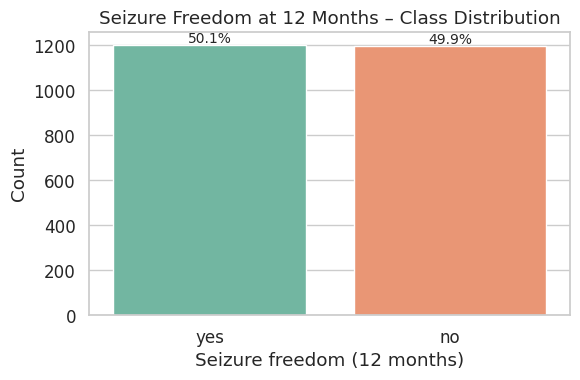

In [12]:
# Exploratory Data Analysis Setup
target_col = 'seizure_freedom_12months'

# Target Distribution
plt.figure(figsize=(6,4))
ax = sns.countplot(x=target_col, data=df, palette="Set2")
plt.title("Seizure Freedom at 12 Months – Class Distribution")

total = len(df)
for p in ax.patches:
    count = p.get_height()
    pct = 100 * count / total
    ax.annotate(f'{pct:.1f}%',
                (p.get_x() + p.get_width()/2., count),
                ha='center', va='bottom', fontsize=10)

plt.xlabel("Seizure freedom (12 months)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

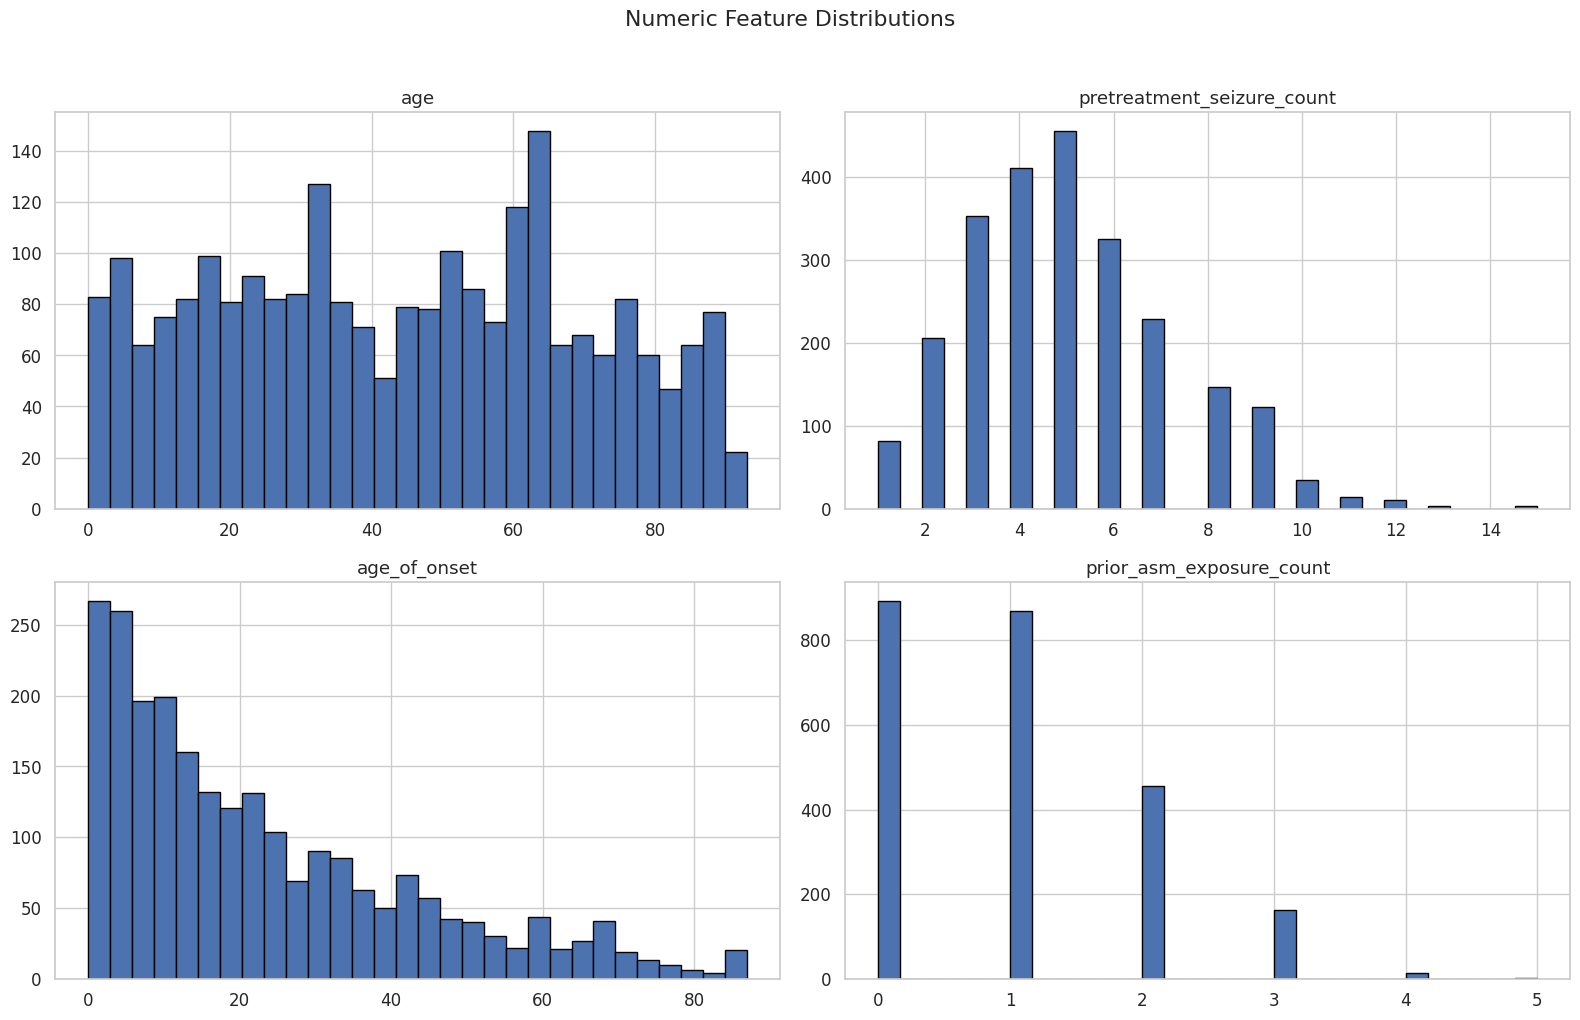

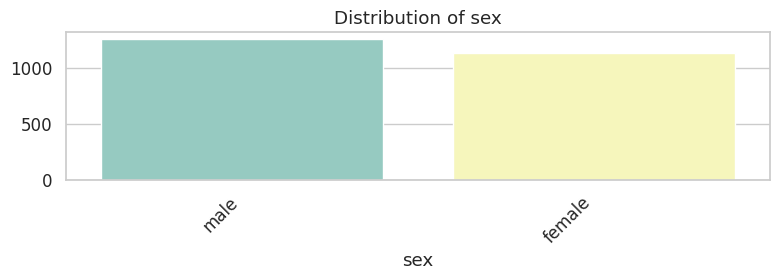

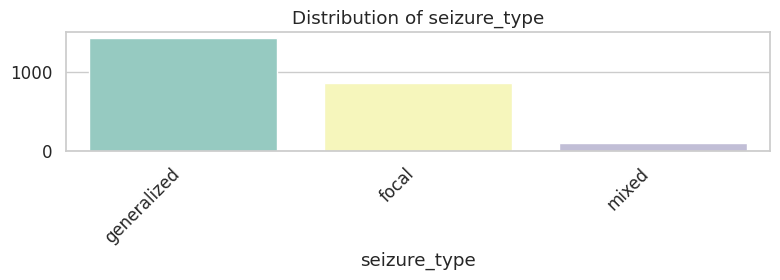

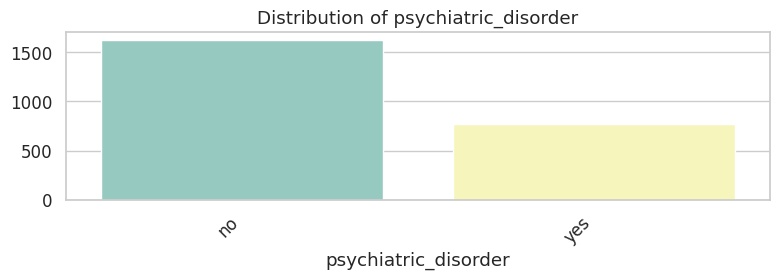

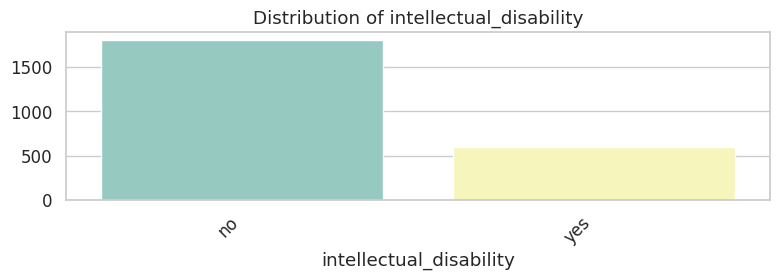

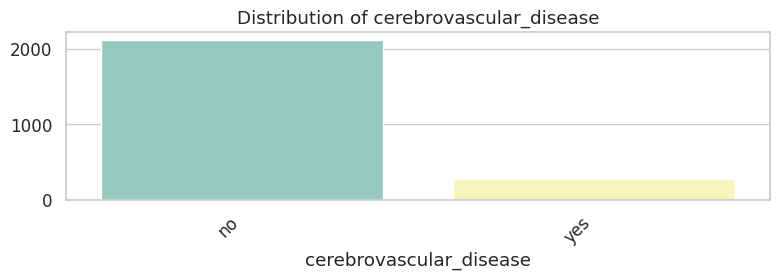

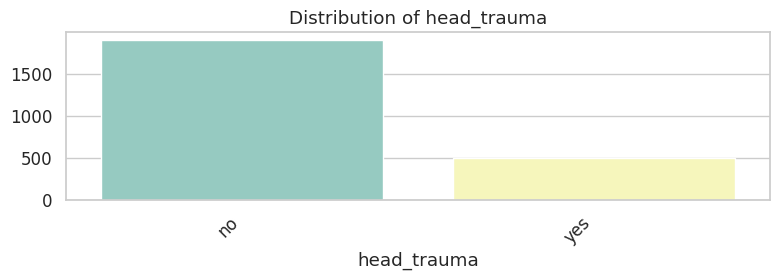

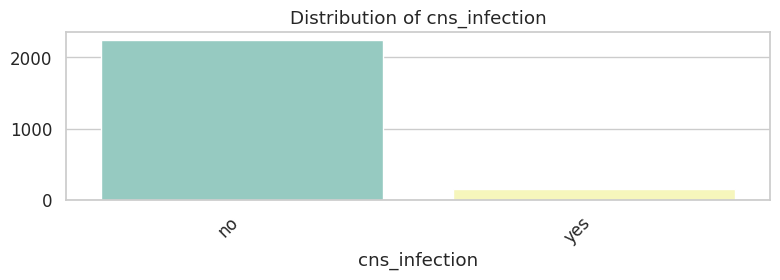

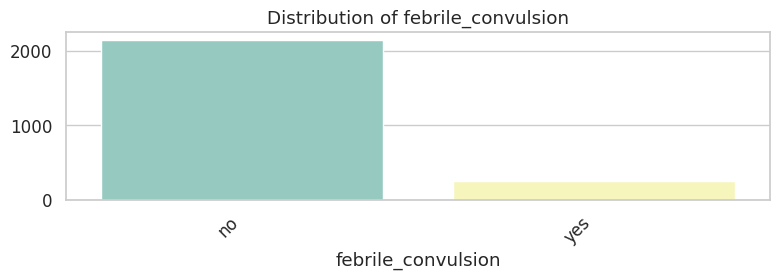

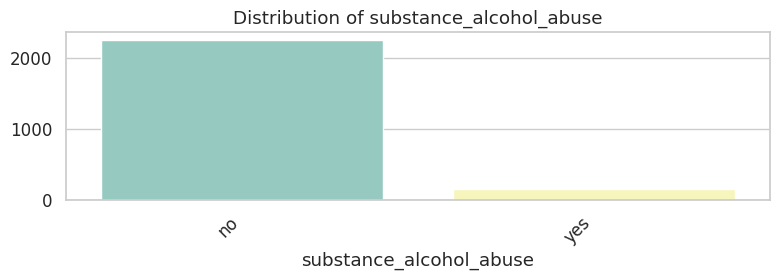

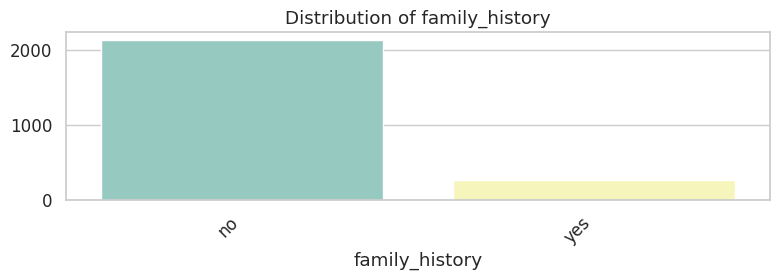

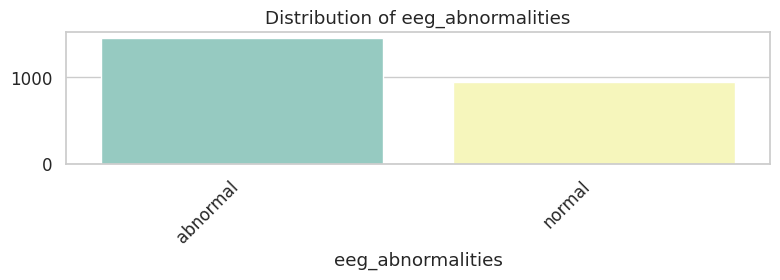

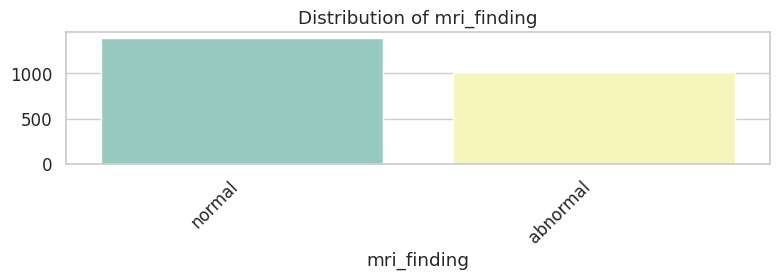

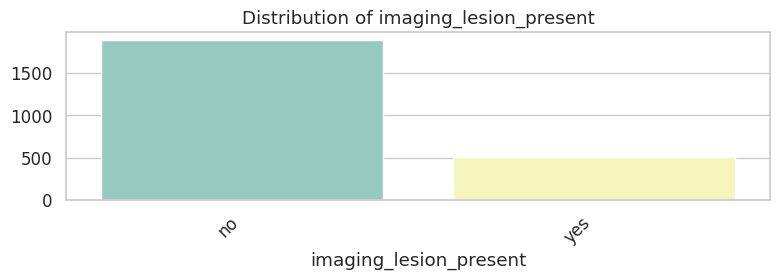

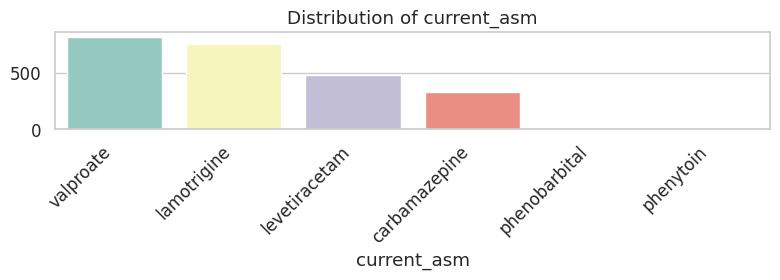

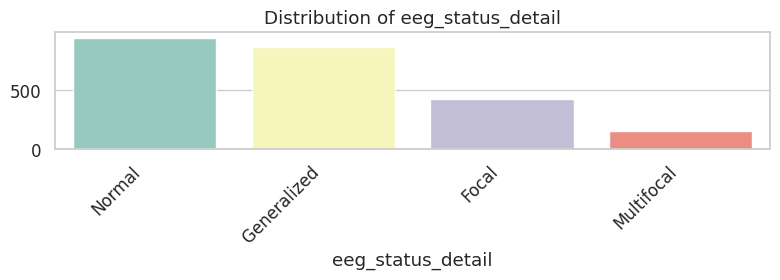

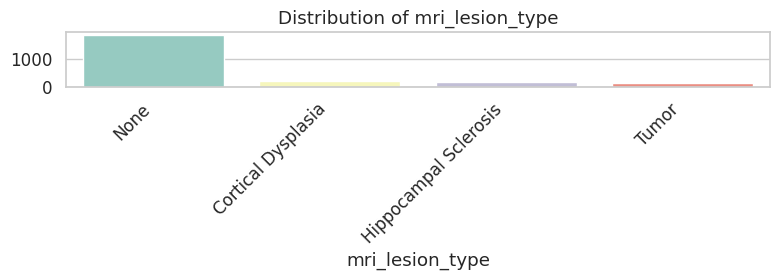

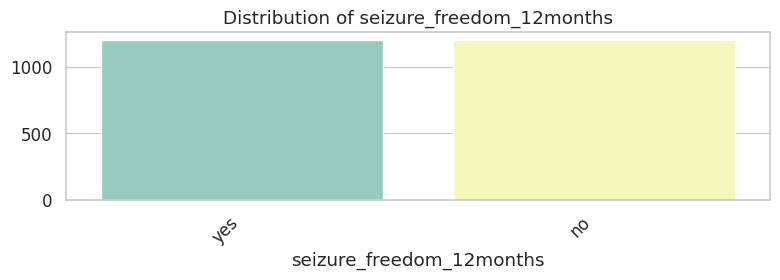

In [13]:
# Numeric & Categorical Distributions
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
numeric_cols_no_target = [c for c in numeric_cols if c != target_col]

# Numeric histograms
if numeric_cols_no_target:
    df[numeric_cols_no_target].hist(bins=30, figsize=(16,10), edgecolor='black')
    plt.suptitle("Numeric Feature Distributions", y=1.02)
    plt.tight_layout()
    plt.show()

# Categorical barplots
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    plt.figure(figsize=(8,3))
    vc = df[col].value_counts().head(20)
    sns.barplot(x=vc.index, y=vc.values, palette="Set3")
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [14]:
# Advanced Feature Engineering

df_fe = df.copy()

# 1. Duration since onset
if {'age', 'age_of_onset'}.issubset(df_fe.columns):
    df_fe['duration_since_onset'] = (df_fe['age'] - df_fe['age_of_onset']).clip(lower=0)

# 2. Seizure burden: raw + log + high burden flag
if 'pretreatment_seizure_count' in df_fe.columns:
    df_fe['seizure_burden_log'] = np.log1p(df_fe['pretreatment_seizure_count'])
    med_seizure = df_fe['pretreatment_seizure_count'].median()
    df_fe['high_seizure_burden'] = (df_fe['pretreatment_seizure_count'] > med_seizure).astype(int)

# 3. Seizure frequency risk (seizures per year of age)
if {'pretreatment_seizure_count', 'age'}.issubset(df_fe.columns):
    df_fe['seizure_frequency_risk'] = df_fe['pretreatment_seizure_count'] / (df_fe['age'] + 1)

# 4. ASM exposure features
if 'prior_asm_exposure_count' in df_fe.columns:
    df_fe['high_prior_asm'] = (df_fe['prior_asm_exposure_count'] > 1).astype(int)
    df_fe['poly_asm_history'] = (df_fe['prior_asm_exposure_count'] >= 3).astype(int)

# 5. Age-of-onset group (infant/child/adult)
if 'age_of_onset' in df_fe.columns:
    df_fe['age_of_onset_group'] = pd.cut(
        df_fe['age_of_onset'],
        bins=[-0.01, 1, 18, 40, 65, 120],
        labels=['Infant', 'Childhood', 'Young_Adult', 'Mid_Age', 'Older'],
        include_lowest=True
    )

# 6. Structural lesion flag from MRI lesion type
if 'mri_lesion_type' in df_fe.columns:
    df_fe['structural_lesion_flag'] = (df_fe['mri_lesion_type'] != 'None').astype(int)

# 7. EEG epileptic flag – any non-normal EEG treated as epileptic
if 'eeg_status_detail' in df_fe.columns:
    eeg_clean = df_fe['eeg_status_detail'].astype(str).str.strip().str.lower()
    df_fe['eeg_epileptic_flag'] = (eeg_clean != 'normal').astype(int)

# 8. Comorbidity burden from yes/no columns
comorb_cols = [
    'psychiatric_disorder', 'intellectual_disability',
    'cerebrovascular_disease', 'head_trauma',
    'cns_infection', 'substance_alcohol_abuse', 'family_history'
]
existing_comorb = [c for c in comorb_cols if c in df_fe.columns]

def norm_yes_no(v):
    v = str(v).strip().lower()
    if v in ['yes', 'y', 'true', '1']:
        return 1
    return 0

if existing_comorb:
    for c in existing_comorb:
        df_fe[c + '_bin'] = df_fe[c].apply(norm_yes_no)
    bin_cols = [c + '_bin' for c in existing_comorb]
    df_fe['comorbidity_burden'] = df_fe[bin_cols].sum(axis=1)
    df_fe['high_comorbidity'] = (df_fe['comorbidity_burden'] > 0).astype(int)

# 9. Clinical risk index (simple additive score)
risk_components = [
    col for col in [
        'high_seizure_burden', 'structural_lesion_flag',
        'high_prior_asm', 'high_comorbidity', 'eeg_epileptic_flag'
    ] if col in df_fe.columns
]
if risk_components:
    df_fe['clinical_risk_index'] = df_fe[risk_components].sum(axis=1)

print("New engineered columns:")
print(sorted(list(set(df_fe.columns) - set(df.columns)))[:30])

New engineered columns:
['age_of_onset_group', 'cerebrovascular_disease_bin', 'clinical_risk_index', 'cns_infection_bin', 'comorbidity_burden', 'duration_since_onset', 'eeg_epileptic_flag', 'family_history_bin', 'head_trauma_bin', 'high_comorbidity', 'high_prior_asm', 'high_seizure_burden', 'intellectual_disability_bin', 'poly_asm_history', 'psychiatric_disorder_bin', 'seizure_burden_log', 'seizure_frequency_risk', 'structural_lesion_flag', 'substance_alcohol_abuse_bin']


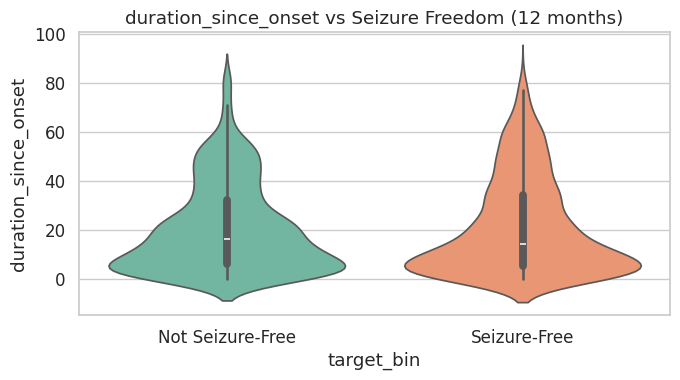

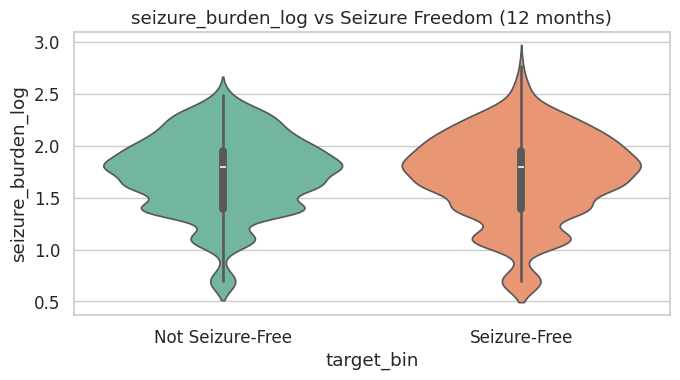

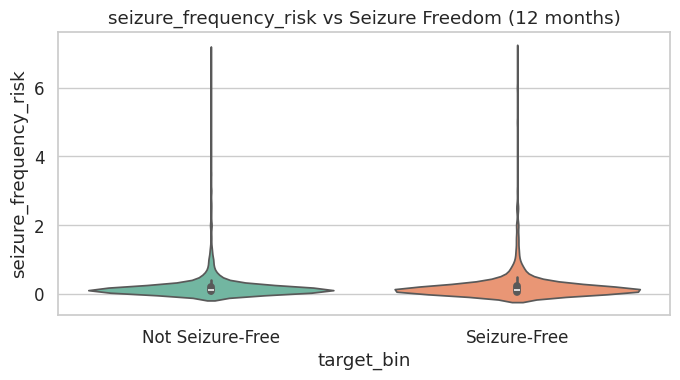

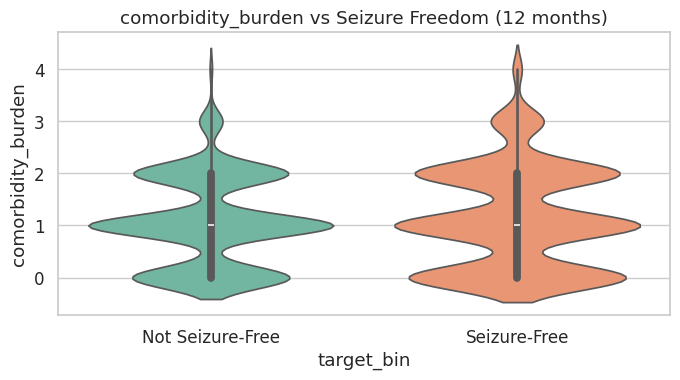

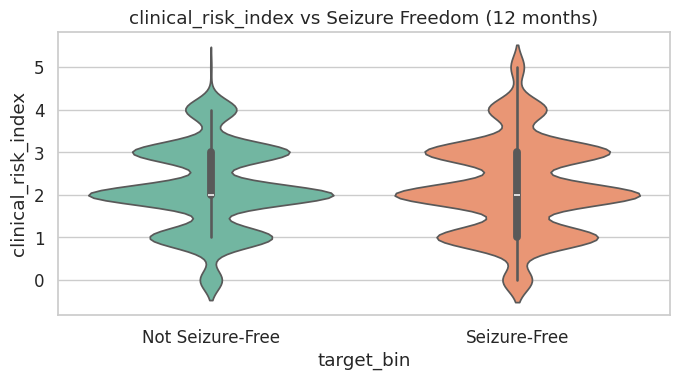

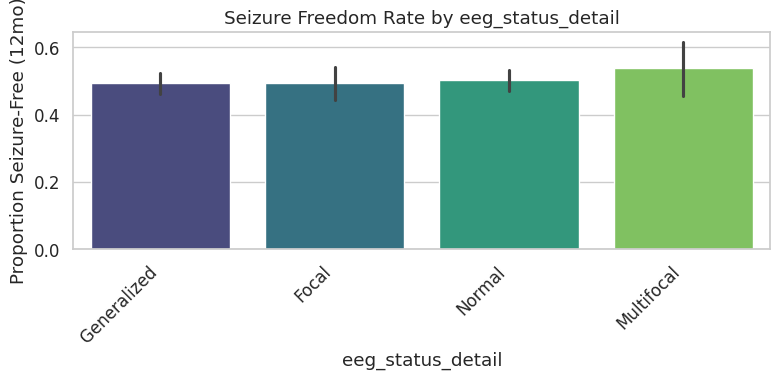

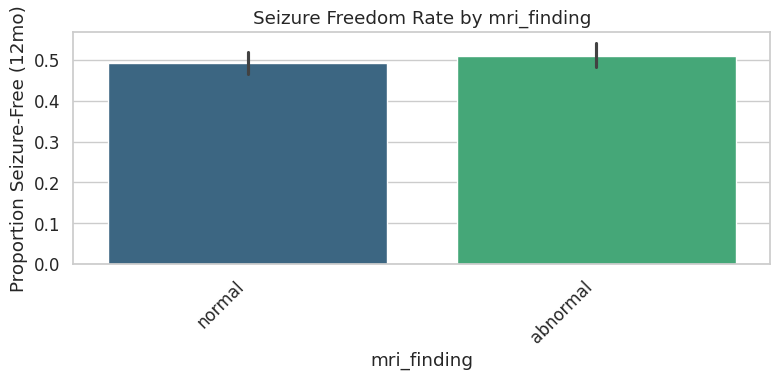

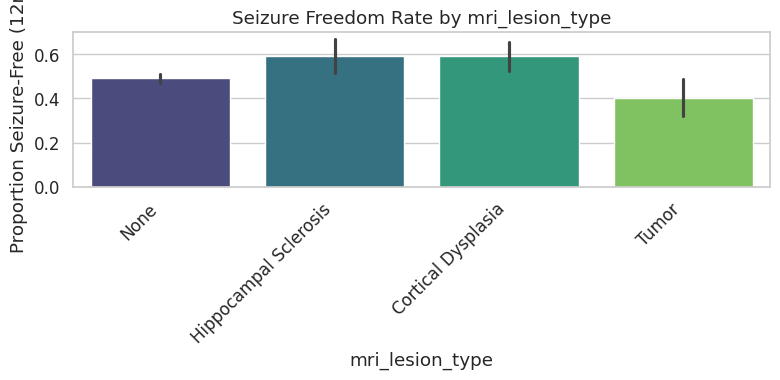

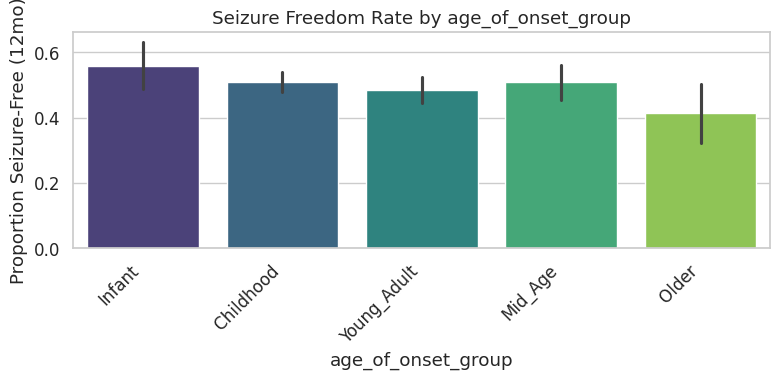

In [15]:
# Numeric Target + Engineered Feature Visualizations

# Create numeric target 0/1
df_fe['target_bin'] = (
    df_fe[target_col]
    .astype(str)
    .str.lower()
    .str.strip()
    .replace({'yes': 1, 'no': 0, '1': 1, '0': 0})
    .astype(int)
)

# Box/violin plots for engineered continuous features vs target
vis_cols = [
    'duration_since_onset',
    'seizure_burden_log',
    'seizure_frequency_risk',
    'comorbidity_burden',
    'clinical_risk_index'
]

for col in vis_cols:
    if col in df_fe.columns:
        plt.figure(figsize=(7,4))
        sns.violinplot(x='target_bin', y=col, data=df_fe, inner="box", palette="Set2")
        plt.title(f"{col} vs Seizure Freedom (12 months)")
        plt.xticks([0,1], ['Not Seizure-Free', 'Seizure-Free'])
        plt.tight_layout()
        plt.show()

# Category-wise seizure freedom rate
cat_vis_cols = ['eeg_status_detail', 'mri_finding', 'mri_lesion_type', 'age_of_onset_group']

for col in cat_vis_cols:
    if col in df_fe.columns:
        plt.figure(figsize=(8,4))
        sns.barplot(
            x=col,
            y='target_bin',
            data=df_fe,
            estimator=np.mean,
            palette="viridis"
        )
        plt.xticks(rotation=45, ha='right')
        plt.ylabel("Proportion Seizure-Free (12mo)")
        plt.title(f"Seizure Freedom Rate by {col}")
        plt.tight_layout()
        plt.show()

In [16]:
# Prepare Data for Modelling (Encoding, Split, Scaling)
y = df_fe['target_bin']
X = df_fe.drop(columns=[target_col, 'target_bin'])

# Identify feature types
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Label encode categorical variables
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

# Scale numeric features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
if num_cols:
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])

print("X_train shape:", X_train.shape, "| X_test shape:", X_test.shape)
print("y_train distribution:", np.bincount(y_train))

Categorical columns: ['sex', 'seizure_type', 'psychiatric_disorder', 'intellectual_disability', 'cerebrovascular_disease', 'head_trauma', 'cns_infection', 'febrile_convulsion', 'substance_alcohol_abuse', 'family_history', 'eeg_abnormalities', 'mri_finding', 'imaging_lesion_present', 'current_asm', 'eeg_status_detail', 'mri_lesion_type', 'age_of_onset_group']
Numeric columns: ['age', 'pretreatment_seizure_count', 'age_of_onset', 'prior_asm_exposure_count', 'duration_since_onset', 'seizure_burden_log', 'high_seizure_burden', 'seizure_frequency_risk', 'high_prior_asm', 'poly_asm_history', 'structural_lesion_flag', 'eeg_epileptic_flag', 'psychiatric_disorder_bin', 'intellectual_disability_bin', 'cerebrovascular_disease_bin', 'head_trauma_bin', 'cns_infection_bin', 'substance_alcohol_abuse_bin', 'family_history_bin', 'comorbidity_burden', 'high_comorbidity', 'clinical_risk_index']
X_train shape: (1916, 39) | X_test shape: (480, 39)
y_train distribution: [956 960]


In [17]:
X_train

,age,sex,pretreatment_seizure_count,seizure_type,age_of_onset,psychiatric_disorder,intellectual_disability,cerebrovascular_disease,head_trauma,cns_infection,...,psychiatric_disorder_bin,intellectual_disability_bin,cerebrovascular_disease_bin,head_trauma_bin,cns_infection_bin,substance_alcohol_abuse_bin,family_history_bin,comorbidity_burden,high_comorbidity,clinical_risk_index
1179,-0.256269,1,-0.458266,1,-0.882853,0,0,0,0,0,...,-0.699095,-0.578154,-0.371170,-0.519341,-0.266438,-0.258486,-0.359237,-1.253716,-1.627736,-1.142597
2300,-0.137782,0,-0.458266,1,0.214097,0,0,1,0,0,...,-0.699095,-0.578154,2.694183,-0.519341,-0.266438,-0.258486,2.783677,0.916221,0.614350,-0.174774
1225,-1.085680,1,2.233724,1,-0.583685,0,0,0,0,0,...,-0.699095,-0.578154,-0.371170,-0.519341,-0.266438,-0.258486,-0.359237,-1.253716,-1.627736,-1.142597
1601,0.810116,1,0.439064,0,0.513265,0,1,0,0,0,...,-0.699095,1.729644,-0.371170,-0.519341,-0.266438,-0.258486,-0.359237,-0.168748,0.614350,1.760873
862,-0.295765,1,1.336394,1,-1.032437,1,0,0,0,1,...,1.430421,-0.578154,-0.371170,-0.519341,3.753214,-0.258486,-0.359237,0.916221,0.614350,0.793049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,-0.690722,1,0.439064,1,-0.832992,0,0,0,0,0,...,-0.699095,-0.578154,-0.371170,-0.519341,-0.266438,-0.258486,-0.359237,-1.253716,-1.627736,-0.174774
1804,-1.006688,1,2.233724,1,-0.633546,0,0,1,0,0,...,-0.699095,-0.578154,2.694183,-0.519341,-0.266438,-0.258486,-0.359237,-0.168748,0.614350,-0.174774
240,-0.295765,1,0.887729,1,-0.384240,0,1,0,1,0,...,-0.699095,1.729644,-0.371170,1.925517,-0.266438,-0.258486,-0.359237,0.916221,0.614350,1.760873
2357,-0.809209,1,1.785059,0,-0.035210,0,0,0,0,0,...,-0.699095,-0.578154,-0.371170,-0.519341,-0.266438,-0.258486,-0.359237,-1.253716,-1.627736,-0.174774


In [18]:
# SMOTE + Train Logistic, RF, XGB, LGBM
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
print("After SMOTE:", X_train_bal.shape, "Class counts:", np.bincount(y_train_bal))

models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, class_weight='balanced', random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=300, max_depth=12, random_state=42, n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=400, max_depth=5, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric='logloss', random_state=42
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=400, learning_rate=0.05,
        num_leaves=31, subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1
    )
}

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    print(f"Trained: {name}")

After SMOTE: (1920, 39) Class counts: [960 960]
Trained: Logistic Regression
Trained: Random Forest
Trained: XGBoost
[LightGBM] [Info] Number of positive: 960, number of negative: 960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 1920, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Trained: LightGBM


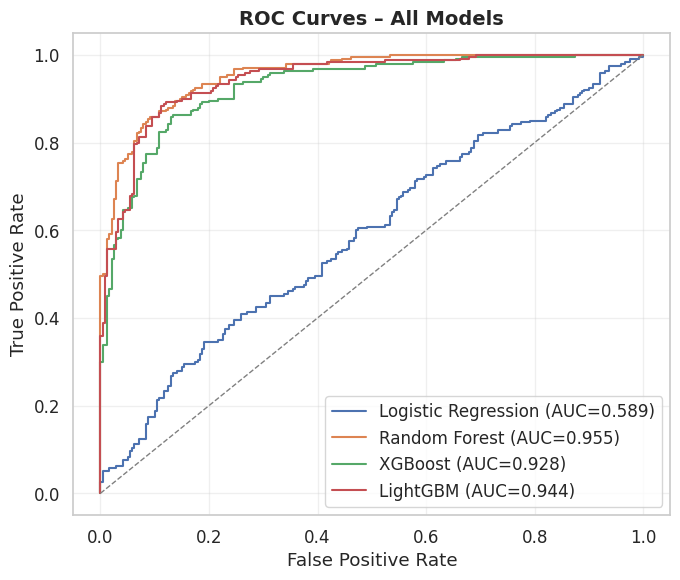


Model Performance Comparison:
              Model  Accuracy  Precision   Recall       F1  ROC_AUC    Brier
      Random Forest  0.877083   0.888412 0.862500 0.875264 0.955278 0.123735
           LightGBM  0.877083   0.885106 0.866667 0.875789 0.944063 0.092330
            XGBoost  0.860417   0.868085 0.850000 0.858947 0.927812 0.110680
Logistic Regression  0.556250   0.559471 0.529167 0.543897 0.588646 0.244205


In [19]:
# Evaluate Models + ROC Curves
results = []

plt.figure(figsize=(7,6))

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    brier = brier_score_loss(y_test, y_prob)

    results.append([name, acc, prec, rec, f1, auc, brier])

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],"--", color="gray", linewidth=1)
plt.title("ROC Curves – All Models", fontsize=14, fontweight='bold')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results, columns=['Model','Accuracy','Precision','Recall','F1','ROC_AUC','Brier'])
print("\nModel Performance Comparison:")
print(results_df.sort_values("ROC_AUC", ascending=False).to_string(index=False))


Best model: Random Forest


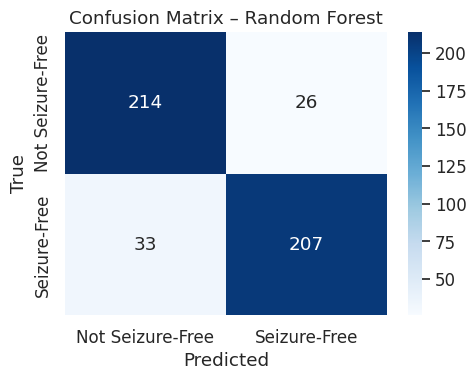


Classification Report:
                  precision    recall  f1-score   support

Not Seizure-Free       0.87      0.89      0.88       240
    Seizure-Free       0.89      0.86      0.88       240

        accuracy                           0.88       480
       macro avg       0.88      0.88      0.88       480
    weighted avg       0.88      0.88      0.88       480



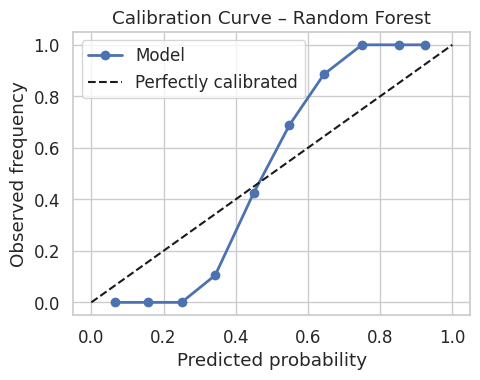

In [20]:
# Best Model Analysis – Confusion Matrix & Calibration Curve

best_model_name = results_df.sort_values("ROC_AUC", ascending=False).iloc[0]['Model']
best_model = models[best_model_name]
print("Best model:", best_model_name)

# Confusion matrix
cm = confusion_matrix(y_test, best_model.predict(X_test))
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Seizure-Free','Seizure-Free'],
            yticklabels=['Not Seizure-Free','Seizure-Free'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – {best_model_name}")
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, best_model.predict(X_test), target_names=['Not Seizure-Free','Seizure-Free']))

# Calibration curve
y_prob_best = best_model.predict_proba(X_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_prob_best, n_bins=10)

plt.figure(figsize=(5,4))
plt.plot(prob_pred, prob_true, marker='o', label='Model', linewidth=2)
plt.plot([0,1],[0,1],'k--', label='Perfectly calibrated')
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title(f"Calibration Curve – {best_model_name}")
plt.legend()
plt.tight_layout()
plt.show()


📊 TOP 15 MOST IMPORTANT FEATURES:
                   Feature  Importance
              age_of_onset    0.101172
    seizure_frequency_risk    0.100887
                       age    0.089467
      duration_since_onset    0.083473
        seizure_burden_log    0.054486
pretreatment_seizure_count    0.053496
       clinical_risk_index    0.039683
  prior_asm_exposure_count    0.033619
        comorbidity_burden    0.033026
         eeg_status_detail    0.026824
        age_of_onset_group    0.024639
               current_asm    0.024500
           mri_lesion_type    0.023218
                       sex    0.023188
              seizure_type    0.022381


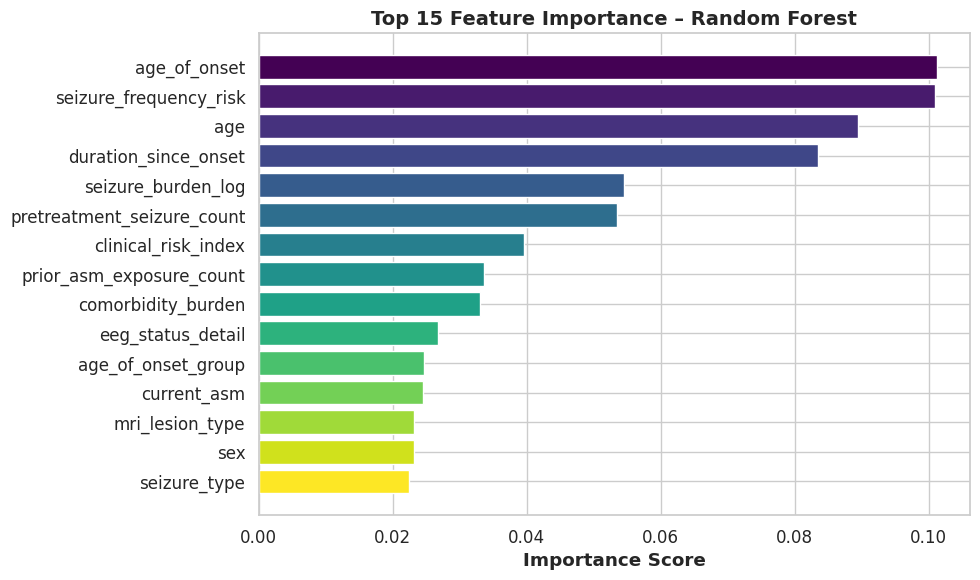

In [21]:
# FEATURE IMPORTANCE
if best_model_name in ['Random Forest', 'XGBoost', 'LightGBM']:
  feature_importance = best_model.feature_importances_
  feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\n📊 TOP 15 MOST IMPORTANT FEATURES:")
print(importance_df.head(15).to_string(index=False))

# Plot
plt.figure(figsize=(10,6))
top_15 = importance_df.head(15)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_15)))
plt.barh(range(len(top_15)), top_15['Importance'], color=colors)
plt.yticks(range(len(top_15)), top_15['Feature'])
plt.xlabel('Importance Score', fontweight='bold')
plt.title(f'Top 15 Feature Importance – {best_model_name}', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
#  PREDICT SEIZURE FREEDOM (12 MONTHS) FOR NEW PATIENTS

# 1. Wrap feature engineering into a function
def engineer_features_single(df_input):
    df_fe = df_input.copy()

    # 1. Duration since onset
    if {'age', 'age_of_onset'}.issubset(df_fe.columns):
        df_fe['duration_since_onset'] = (df_fe['age'] - df_fe['age_of_onset']).clip(lower=0)

    # 2. Seizure burden: raw + log + high burden flag
    if 'pretreatment_seizure_count' in df_fe.columns:
        df_fe['seizure_burden_log'] = np.log1p(df_fe['pretreatment_seizure_count'])
        med_seizure = df['pretreatment_seizure_count'].median()  # use training median
        df_fe['high_seizure_burden'] = (df_fe['pretreatment_seizure_count'] > med_seizure).astype(int)

    # 3. Seizure frequency risk (seizures per year of age)
    if {'pretreatment_seizure_count', 'age'}.issubset(df_fe.columns):
        df_fe['seizure_frequency_risk'] = df_fe['pretreatment_seizure_count'] / (df_fe['age'] + 1)

    # 4. ASM exposure features
    if 'prior_asm_exposure_count' in df_fe.columns:
        df_fe['high_prior_asm'] = (df_fe['prior_asm_exposure_count'] > 1).astype(int)
        df_fe['poly_asm_history'] = (df_fe['prior_asm_exposure_count'] >= 3).astype(int)

    # 5. Age-of-onset group (infant/child/adult)
    if 'age_of_onset' in df_fe.columns:
        df_fe['age_of_onset_group'] = pd.cut(
            df_fe['age_of_onset'],
            bins=[-0.01, 1, 18, 40, 65, 120],
            labels=['Infant', 'Childhood', 'Young_Adult', 'Mid_Age', 'Older'],
            include_lowest=True
        )

    # 6. Structural lesion flag from MRI lesion type
    if 'mri_lesion_type' in df_fe.columns:
        df_fe['structural_lesion_flag'] = (df_fe['mri_lesion_type'] != 'None').astype(int)

    # 7. EEG epileptic flag – any non-normal EEG treated as epileptic
    if 'eeg_status_detail' in df_fe.columns:
        eeg_clean = df_fe['eeg_status_detail'].astype(str).str.strip().str.lower()
        df_fe['eeg_epileptic_flag'] = (eeg_clean != 'normal').astype(int)

    # 8. Comorbidity burden from yes/no columns (reuse comorb_cols + norm_yes_no)
    existing_comorb = [c for c in [
        'psychiatric_disorder', 'intellectual_disability',
        'cerebrovascular_disease', 'head_trauma',
        'cns_infection', 'substance_alcohol_abuse', 'family_history'
    ] if c in df_fe.columns]

    if existing_comorb:
        for c in existing_comorb:
            df_fe[c + '_bin'] = df_fe[c].apply(norm_yes_no)
        bin_cols = [c + '_bin' for c in existing_comorb]
        df_fe['comorbidity_burden'] = df_fe[bin_cols].sum(axis=1)
        df_fe['high_comorbidity'] = (df_fe['comorbidity_burden'] > 0).astype(int)

    # 9. Clinical risk index (simple additive score)
    risk_components = [
        col for col in [
            'high_seizure_burden', 'structural_lesion_flag',
            'high_prior_asm', 'high_comorbidity', 'eeg_epileptic_flag'
        ] if col in df_fe.columns
    ]
    if risk_components:
        df_fe['clinical_risk_index'] = df_fe[risk_components].sum(axis=1)

    return df_fe


# 2. Helper – take a dictionary, make it model-ready (same pipeline as training)
def prepare_sample_for_model(sample_dict):
    # Create DataFrame and standardize column names like before
    sample_df = pd.DataFrame([sample_dict])
    sample_df.columns = sample_df.columns.str.strip().str.lower().str.replace(' ', '_')

    # Make sure MRI lesion type has 'None' instead of NaN
    if 'mri_lesion_type' in sample_df.columns:
        sample_df['mri_lesion_type'] = sample_df['mri_lesion_type'].fillna('None')
    elif 'mri_lesion_type' in df.columns:
        # if user didn't provide it, default to 'None'
        sample_df['mri_lesion_type'] = 'None'

    # Ensure all original base columns exist; fill with reasonable defaults
    for col in df.columns:
        if col not in sample_df.columns:
            if df[col].dtype == 'O':
                sample_df[col] = df[col].mode()[0]  # most common category
            else:
                sample_df[col] = df[col].median()   # median numeric value

    # Apply the same feature engineering as training
    sample_fe = engineer_features_single(sample_df)

    # Drop target columns if user accidentally provided them
    for col in [target_col, 'target_bin']:
        if col in sample_fe.columns:
            sample_fe = sample_fe.drop(columns=[col])

    # Ensure all model features exist
    for col in X_train.columns:
        if col not in sample_fe.columns:
            if col in cat_cols:
                sample_fe[col] = 'Unknown'
            else:
                sample_fe[col] = 0.0

    # Reorder to match training feature order
    sample_X = sample_fe[X_train.columns].copy()

    # Label encode categorical columns using the fitted encoders
    for col in cat_cols:
        vals = sample_X[col].astype(str)
        le = label_encoders[col]

        # Handle unseen categories by extending classes_
        unseen = set(vals.unique()) - set(le.classes_)
        if unseen:
            le.classes_ = np.concatenate([le.classes_, np.array(list(unseen))])
        sample_X[col] = le.transform(vals)

    # Scale numeric columns using the fitted scaler
    if num_cols:
        sample_X[num_cols] = scaler.transform(sample_X[num_cols])

    return sample_X


# 3. Function to print a nice prediction summary
def predict_seizure_freedom(sample_dict, threshold=0.5):
    sample_X = prepare_sample_for_model(sample_dict)
    prob = best_model.predict_proba(sample_X)[:, 1][0]
    pred_class = int(prob >= threshold)

    label = "Seizure-Free at 12 months" if pred_class == 1 else "NOT Seizure-Free at 12 months"

    print("-------------------------------------------------")
    print(" Predicted probability of being seizure-free (12m): {:.3f}".format(prob))
    print(" Classification (threshold = {:.2f}): {}".format(threshold, label))
    print("-------------------------------------------------")
    return prob, pred_class


# 4. EXAMPLE: test with a sample patient
sample_patient = {
    "age": 28,
    "age_of_onset": 26,
    "pretreatment_seizure_count": 12,
    "prior_asm_exposure_count": 1,

    "current_asm": "Levetiracetam",
    "seizure_type": "Focal",
    "sex": "Female",

    "mri_lesion_type": "None",
    "mri_finding": "Normal",
    "eeg_status_detail": "Normal",

    "psychiatric_disorder": "No",
    "intellectual_disability": "No",
    "cerebrovascular_disease": "No",
    "head_trauma": "No",
    "cns_infection": "No",
    "substance_alcohol_abuse": "No",
    "family_history": "No"
}

prob, pred = predict_seizure_freedom(sample_patient)

-------------------------------------------------
 Predicted probability of being seizure-free (12m): 0.716
 Classification (threshold = 0.50): Seizure-Free at 12 months
-------------------------------------------------


In [ ]:
# EXPLAINABLE AI (XAI) – SHAP (optional) + DOCTOR-STYLE EXPLANATION

shap.initjs()

# 1. Build a SHAP explainer for the best model (not strictly used in explanation now,
#    but you can still use it later for plots if it works in your env)
if best_model_name in ["Random Forest", "XGBoost", "LightGBM"]:
    explainer = shap.TreeExplainer(best_model)
    shap_model_type = "tree"
else:
    explainer = shap.LinearExplainer(best_model, X_train, feature_perturbation="independent")
    shap_model_type = "linear"

print(f"SHAP explainer created for: {best_model_name} ({shap_model_type} model)")

# 2. Feature engineering for a single sample (same as training)
def engineer_features_single(df_input):
    df_fe = df_input.copy()

    # 1. Duration since onset
    if {'age', 'age_of_onset'}.issubset(df_fe.columns):
        df_fe['duration_since_onset'] = (df_fe['age'] - df_fe['age_of_onset']).clip(lower=0)

    # 2. Seizure burden: raw + log + high burden flag
    if 'pretreatment_seizure_count' in df_fe.columns:
        df_fe['seizure_burden_log'] = np.log1p(df_fe['pretreatment_seizure_count'])
        med_seizure = df['pretreatment_seizure_count'].median()  # from original dataset
        df_fe['high_seizure_burden'] = (df_fe['pretreatment_seizure_count'] > med_seizure).astype(int)

    # 3. Seizure frequency risk
    if {'pretreatment_seizure_count', 'age'}.issubset(df_fe.columns):
        df_fe['seizure_frequency_risk'] = df_fe['pretreatment_seizure_count'] / (df_fe['age'] + 1)

    # 4. ASM exposure features
    if 'prior_asm_exposure_count' in df_fe.columns:
        df_fe['high_prior_asm'] = (df_fe['prior_asm_exposure_count'] > 1).astype(int)
        df_fe['poly_asm_history'] = (df_fe['prior_asm_exposure_count'] >= 3).astype(int)

    # 5. Age-of-onset group
    if 'age_of_onset' in df_fe.columns:
        df_fe['age_of_onset_group'] = pd.cut(
            df_fe['age_of_onset'],
            bins=[-0.01, 1, 18, 40, 65, 120],
            labels=['Infant', 'Childhood', 'Young_Adult', 'Mid_Age', 'Older'],
            include_lowest=True
        )

    # 6. Structural lesion flag from MRI lesion type
    if 'mri_lesion_type' in df_fe.columns:
        df_fe['structural_lesion_flag'] = (df_fe['mri_lesion_type'] != 'None').astype(int)

    # 7. EEG epileptic flag
    if 'eeg_status_detail' in df_fe.columns:
        eeg_clean = df_fe['eeg_status_detail'].astype(str).str.strip().str.lower()
        df_fe['eeg_epileptic_flag'] = (eeg_clean != 'normal').astype(int)

    # 8. Comorbidity burden
    existing_comorb = [c for c in [
        'psychiatric_disorder', 'intellectual_disability',
        'cerebrovascular_disease', 'head_trauma',
        'cns_infection', 'substance_alcohol_abuse', 'family_history'
    ] if c in df_fe.columns]

    if existing_comorb:
        for c in existing_comorb:
            df_fe[c + '_bin'] = df_fe[c].apply(norm_yes_no)
        bin_cols = [c + '_bin' for c in existing_comorb]
        df_fe['comorbidity_burden'] = df_fe[bin_cols].sum(axis=1)
        df_fe['high_comorbidity'] = (df_fe['comorbidity_burden'] > 0).astype(int)

    # 9. Clinical risk index
    risk_components = [
        col for col in [
            'high_seizure_burden', 'structural_lesion_flag',
            'high_prior_asm', 'high_comorbidity', 'eeg_epileptic_flag'
        ] if col in df_fe.columns
    ]
    if risk_components:
        df_fe['clinical_risk_index'] = df_fe[risk_components].sum(axis=1)

    return df_fe

# 3. Prepare a single sample for the model + keep unscaled copy for explanation
def prepare_sample_for_model(sample_dict):
    # sample_dict is scalar-only
    sample_df = pd.DataFrame([sample_dict])

    # Standardize column names
    sample_df.columns = sample_df.columns.str.strip().str.lower().str.replace(' ', '_')

    # Ensure MRI lesion type exists
    if 'mri_lesion_type' in sample_df.columns:
        sample_df['mri_lesion_type'] = sample_df['mri_lesion_type'].fillna('None')
    elif 'mri_lesion_type' in df.columns:
        sample_df['mri_lesion_type'] = 'None'

    # Ensure all base columns from original df exist
    for col in df.columns:
        if col not in sample_df.columns:
            if df[col].dtype == 'O':
                sample_df[col] = df[col].mode()[0]
            else:
                sample_df[col] = df[col].median()

    # Apply same feature engineering
    sample_fe = engineer_features_single(sample_df)

    # Drop any target columns if present
    for col in [target_col, 'target_bin']:
        if col in sample_fe.columns:
            sample_fe = sample_fe.drop(columns=[col])

    # Ensure all model features exist
    for col in X_train.columns:
        if col not in sample_fe.columns:
            if col in cat_cols:
                sample_fe[col] = 'Unknown'
            else:
                sample_fe[col] = 0.0

    # Keep ORIGINAL (unencoded, unscaled) for explanation
    sample_fe_for_explanation = sample_fe.copy()

    # Build model input: start from same features, then encode/scale
    sample_X = sample_fe.copy()

    # Encode categoricals using fitted encoders
    for col in cat_cols:
        vals = sample_X[col].astype(str)
        le = label_encoders[col]
        unseen = set(vals.unique()) - set(le.classes_)
        if unseen:
            le.classes_ = np.concatenate([le.classes_, np.array(list(unseen))])
        sample_X[col] = le.transform(vals)

    # Scale numeric features using the fitted scaler
    if num_cols:
        sample_X[num_cols] = scaler.transform(sample_X[num_cols])

    # Reorder to match training feature order
    sample_X = sample_X[X_train.columns].copy()

    return sample_X, sample_fe_for_explanation


# 4. Friendly clinical names
friendly_feature_names = {
    'age': 'current age',
    'age_of_onset': 'age when seizures first started',
    'duration_since_onset': 'duration since seizure onset',
    'pretreatment_seizure_count': 'number of seizures before this treatment',
    'seizure_burden_log': 'overall seizure burden',
    'seizure_frequency_risk': 'seizure frequency relative to age',
    'prior_asm_exposure_count': 'number of anti-seizure medications tried in the past',
    'high_prior_asm': 'history of needing more than one medication',
    'poly_asm_history': 'history of using three or more medications at once',
    'structural_lesion_flag': 'presence of a structural lesion on MRI',
    'mri_lesion_type': 'type of lesion seen on MRI',
    'eeg_epileptic_flag': 'epileptic activity on EEG',
    'comorbidity_burden': 'overall medical/psychiatric comorbidity burden',
    'high_seizure_burden': 'high seizure burden before treatment',
    'high_comorbidity': 'significant additional medical or psychiatric problems',
    'clinical_risk_index': 'overall clinical risk index based on seizures, MRI, EEG and comorbidities',
    'age_of_onset_group': 'age group when seizures began'
}

# 5. Prediction + explanation (model-based importance)

def predict_seizure_freedom_with_explanation(sample_dict, threshold=0.5, top_n=5):
    # sample_X → encoded + scaled (for model)
    # sample_fe_orig → original clinical values after feature engineering
    sample_X, sample_fe_orig = prepare_sample_for_model(sample_dict)

    # Predicted probability and class
    prob = best_model.predict_proba(sample_X)[:, 1][0]
    pred_class = int(prob >= threshold)
    label = "Seizure-Free at 12 months" if pred_class == 1 else "NOT Seizure-Free at 12 months"

    print("-------------------------------------------------")
    print(" 🔮 MODEL PREDICTION")
    print("  • Predicted probability of being seizure-free (12m): {:.3f}".format(prob))
    print("  • Classification (threshold = {:.2f}): {}".format(threshold, label))
    print("-------------------------------------------------")

    # ===== Model-based importance (no SHAP numeric issues) =====
    feature_names = np.array(X_train.columns)

    if hasattr(best_model, "feature_importances_"):
        importance_vec = np.array(best_model.feature_importances_)
    else:
        importance_vec = np.abs(best_model.coef_[0])

    idx = np.argsort(-importance_vec)[:top_n]
    top_features = feature_names[idx]
    top_importances = importance_vec[idx]

    print("\n🩺 EXPLANATION\n")

    if pred_class == 1:
        print("“Looking at your overall profile, the model suggests a relatively favourable chance")
        print("of achieving seizure freedom over the next 12 months. Let me explain this in simple terms.”\n")
    else:
        print("“Based on your current clinical profile, the model estimates a lower chance")
        print("of becoming fully seizure-free over the next 12 months. I’ll walk you through the main reasons.”\n")

    print("Key factors that influenced this assessment:")

    top_values_for_patient = []

    for feat, imp in zip(top_features, top_importances):
        # Use ORIGINAL (unscaled) value if available; otherwise fall back to model input
        if feat in sample_fe_orig.columns:
            raw_val = sample_fe_orig.iloc[0][feat]
        else:
            raw_val = sample_X.iloc[0][feat]

        top_values_for_patient.append(raw_val)

        nice_name = friendly_feature_names.get(feat, feat.replace('_', ' '))
        explanation_line = ""

        # Feature-specific narratives using real clinical values
        if feat == 'pretreatment_seizure_count':
            explanation_line = (
                f"- The {nice_name} is around {float(raw_val):.0f}. "
                f"This number of seizures before starting the current regimen is one of the strongest factors the model uses "
                f"to judge how likely you are to become seizure-free."
            )
        elif feat == 'age':
            explanation_line = (
                f"- Your {nice_name} is about {float(raw_val):.0f} years. "
                f"Age influences how epilepsy behaves and how well treatments work, so the model pays close attention to this."
            )
        elif feat == 'age_of_onset':
            explanation_line = (
                f"- The {nice_name} is around {float(raw_val):.0f} years. "
                f"Epilepsy that starts earlier in life can be more complex, and this timing is an important factor in the model’s assessment."
            )
        elif feat == 'duration_since_onset':
            explanation_line = (
                f"- The {nice_name} is about {float(raw_val):.1f} years. "
                f"The time between seizure onset and current treatment is clinically relevant, and the model incorporates this duration into its prediction."
            )
        elif feat == 'structural_lesion_flag':
            if raw_val == 1:
                explanation_line = (
                    f"- There is a structural lesion on MRI. "
                    f"This kind of structural change in the brain often makes seizure control more challenging, "
                    f"so it weighs heavily in the model’s prediction."
                )
            else:
                explanation_line = (
                    f"- No significant structural lesion on MRI was identified. "
                    f"This is generally a favourable sign and is taken into account by the model when estimating your outlook."
                )
        elif feat == 'eeg_epileptic_flag':
            if raw_val == 1:
                explanation_line = (
                    f"- Your EEG shows epileptic activity. "
                    f"The presence and pattern of EEG abnormalities are key clinical clues about seizure tendency, "
                    f"so the model uses this strongly in its decision."
                )
            else:
                explanation_line = (
                    f"- The EEG does not show definite epileptic discharges, "
                    f"which is often reassuring and contributes positively to the overall assessment."
                )
        elif feat == 'prior_asm_exposure_count':
            explanation_line = (
                f"- You have tried about {float(raw_val):.0f} anti-seizure medications in the past. "
                f"If many medications were needed or were not fully effective, it can suggest a more resistant form of epilepsy, "
                f"so this history is an important factor in the model’s evaluation."
            )
        elif feat == 'comorbidity_burden':
            explanation_line = (
                f"- Your overall comorbidity burden (other medical or psychiatric issues) is approximately {float(raw_val):.0f}. "
                f"Co-existing conditions can influence both seizure control and tolerability of treatment, "
                f"so they are included in the risk assessment."
            )
        elif feat == 'clinical_risk_index':
            explanation_line = (
                f"- The overall clinical risk index (combining seizures, MRI, EEG and comorbidities) is {float(raw_val):.1f}. "
                f"This summary score captures several aspects of your epilepsy and is a major driver of the prediction."
            )
        else:
            explanation_line = (
                f"- The feature ‘{nice_name}’ with a value of {raw_val} is one of the more influential factors "
                f"the model uses to estimate your chance of being seizure-free."
            )

        print(explanation_line)


    return prob, pred_class

SHAP explainer created for: Random Forest (tree model)


In [29]:
sample_patient = {
    "age": 28,
    "age_of_onset": 26,
    "pretreatment_seizure_count": 12,
    "prior_asm_exposure_count": 1,

    "current_asm": "Levetiracetam",
    "seizure_type": "Focal",
    "sex": "Female",

    "mri_lesion_type": "None",
    "mri_finding": "Normal",
    "eeg_status_detail": "Normal",

    "psychiatric_disorder": "No",
    "intellectual_disability": "No",
    "cerebrovascular_disease": "No",
    "head_trauma": "No",
    "cns_infection": "No",
    "substance_alcohol_abuse": "No",
    "family_history": "No"
}

prob, pred =predict_seizure_freedom_with_explanation(sample_patient)


-------------------------------------------------
 🔮 MODEL PREDICTION
  • Predicted probability of being seizure-free (12m): 0.716
  • Classification (threshold = 0.50): Seizure-Free at 12 months
-------------------------------------------------

🩺 EXPLANATION

“Looking at your overall profile, the model suggests a relatively favourable chance
of achieving seizure freedom over the next 12 months. Let me explain this in simple terms.”

Key factors that influenced this assessment:
- The age when seizures first started is around 26 years. Epilepsy that starts earlier in life can be more complex, and this timing is an important factor in the model’s assessment.
- The feature ‘seizure frequency relative to age’ with a value of 0.41379310344827586 is one of the more influential factors the model uses to estimate your chance of being seizure-free.
- Your current age is about 28 years. Age influences how epilepsy behaves and how well treatments work, so the model pays close attention to this.


In [47]:
# List of ASMs present in your dataset (edit if needed)
available_asms = df['current_asm'].unique().tolist()
print("Available ASMs in dataset:", available_asms)


def predict_prob_for_asm(patient_dict, asm_name):
    """
    Returns seizure freedom probability if the patient is assumed
    to be treated with 'asm_name'.
    Handles the two possible signatures of prepare_sample_for_model:
    - returns sample_X
    - or (sample_X, sample_fe_for_explanation)
    """
    temp_patient = patient_dict.copy()
    temp_patient['current_asm'] = asm_name

    out = prepare_sample_for_model(temp_patient)

    # If prepare_sample_for_model returns (sample_X, sample_fe_for_explanation)
    if isinstance(out, tuple):
        sample_X = out[0]
    else:
        sample_X = out

    prob = best_model.predict_proba(sample_X)[:, 1][0]
    return prob


def rank_asms_for_patient(patient_dict):
    rows = []

    for asm in available_asms:
        prob = predict_prob_for_asm(patient_dict, asm)
        rows.append([asm, prob])

    df_rank = pd.DataFrame(rows, columns=['ASM', 'probability'])
    df_rank = df_rank.sort_values('probability', ascending=False).reset_index(drop=True)
    return df_rank


def suggest_alternative_asm(patient_dict, threshold=0.50):
    current_asm_raw = patient_dict.get('current_asm', None)

    ranked_df = rank_asms_for_patient(patient_dict)

    # Normalise ASM names for matching (case-insensitive)
    ranked_df['ASM_norm'] = ranked_df['ASM'].str.strip().str.lower()
    current_asm_norm = None
    if current_asm_raw is not None:
        current_asm_norm = str(current_asm_raw).strip().lower()

    print("\n============================================")
    print("MODEL-BASED ASM RANKING FOR THIS PATIENT")
    print("============================================")
    print(
        ranked_df[['ASM', 'probability']]
        .to_string(index=False, formatters={'probability': lambda x: f"{x:.3f}"})
    )

    # Extract best ASM
    best_asm = ranked_df.iloc[0]['ASM']
    best_prob = ranked_df.iloc[0]['probability']

    # Current ASM performance (if present in dataset)
    if current_asm_norm is not None:
        match = ranked_df[ranked_df['ASM_norm'] == current_asm_norm]
        if not match.empty:
            current_prob = match.iloc[0]['probability']
            current_asm_print = match.iloc[0]['ASM']
        else:
            current_prob = None
            current_asm_print = current_asm_raw
    else:
        current_prob = None
        current_asm_print = "Unknown"

    print("\n--------------------------------------------")
    print(f"Current ASM (input): {current_asm_raw}")
    if current_prob is not None:
        print(f"Matched ASM in dataset: {current_asm_print}")
        print(f"Predicted 12-month seizure-freedom probability: {current_prob:.3f}")
    else:
        print("⚠️ Current ASM is not recognised in the dataset, so no direct probability is available.")
    print("--------------------------------------------")

    # Decision logic
    if current_prob is None:
        print("\nℹ️ Since the current ASM is not in the training data,")
        print("   below is the ASM that the model predicts as most promising for this profile:")
        print(f"➡️ Suggested ASM: {best_asm} (estimated probability: {best_prob:.3f})")

    else:
        if current_prob < threshold:
            print("\n⚠️ The model suggests that the current ASM may not provide optimal seizure control.")
            print(f"➡️ Suggested alternative ASM: {best_asm} (estimated probability: {best_prob:.3f})")
        else:
            print("\n✅ The current ASM is predicted to provide a reasonable chance of seizure freedom.")
            print("However, here are the top 3 alternatives you may consider (model-based, non-prescriptive):")
            print(
                ranked_df[['ASM', 'probability']]
                .head(3)
                .to_string(index=False, formatters={'probability': lambda x: f"{x:.3f}"})
            )

    # Return full ranking without the helper column
    return ranked_df[['ASM', 'probability']]


# Run for your sample patient
ranked_asms = suggest_alternative_asm(sample_patient)

Available ASMs in dataset: ['lamotrigine', 'valproate', 'levetiracetam', 'carbamazepine', 'phenobarbital', 'phenytoin']

MODEL-BASED ASM RANKING FOR THIS PATIENT
          ASM probability
carbamazepine       0.734
  lamotrigine       0.732
levetiracetam       0.726
    phenytoin       0.718
    valproate       0.716
phenobarbital       0.714

--------------------------------------------
Current ASM (input): Levetiracetam
Matched ASM in dataset: levetiracetam
Predicted 12-month seizure-freedom probability: 0.726
--------------------------------------------

✅ The current ASM is predicted to provide a reasonable chance of seizure freedom.
However, here are the top 3 alternatives you may consider (model-based, non-prescriptive):
          ASM probability
carbamazepine       0.734
  lamotrigine       0.732
levetiracetam       0.726


In [50]:
# SAVE TRAINED MODEL + PREPROCESSORS AS PKL FILE

import pickle

artifacts = {
    "best_model_name": best_model_name,
    "best_model": best_model,
    "X_train_columns": X_train.columns.tolist(),
    "cat_cols": cat_cols,
    "num_cols": num_cols,
    "label_encoders": label_encoders,
    "scaler": scaler,
    "df_columns": df.columns.tolist()
}

with open("asm_prediction_model.pkl", "wb") as f:
    pickle.dump(artifacts, f)

print("Model artifacts saved as asm_prediction_model.pkl")


Model artifacts saved as asm_prediction_model.pkl


In [51]:
from google.colab import files
files.download("asm_prediction_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>